In [9]:
import pandas as pd
import os
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from classification import *
from evaluation import *
from sklearn.model_selection import train_test_split
from fairlearn.postprocessing import ThresholdOptimizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Set random seeds
seed = 1234
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [3]:
path = 'data/census/adult-preprocessed.csv'
output_dir = 'outputs/census/without_fairness'
os.makedirs(output_dir, exist_ok=True)
file_dataframe = pd.read_csv(path, delimiter=',')

# Columns
CATEGORICAL_COLUMNS = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
BIAS_COLUMNS = ['age', 'race', 'sex']
# BIAS_COLUMNS = [
#     'age', 'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
#     'race_Other', 'race_White', 'sex_Female', 'sex_Male']
LABEL_COLUMN = "income"
NUMERICAL_COLUMNS = ['capital-loss', 'capital-gain', 'age', 'education-num', 'hours-per-week']
IGNORE_COLUMNS = ['is_train']

categorical_columns_df = file_dataframe[CATEGORICAL_COLUMNS]
file_dataframe.drop(columns=CATEGORICAL_COLUMNS, inplace=True)

In [4]:
def min_max_scaling(dataframe):
    scaler = MinMaxScaler()
    for i in NUMERICAL_COLUMNS:
        dataframe[i] = scaler.fit_transform(dataframe[[i]])
    return dataframe

In [5]:
# Calculate negative positive ratio
negative_positive_ratio = sum(file_dataframe[LABEL_COLUMN] == 0) / sum(file_dataframe[LABEL_COLUMN] == 1)

/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packa

[18:23:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


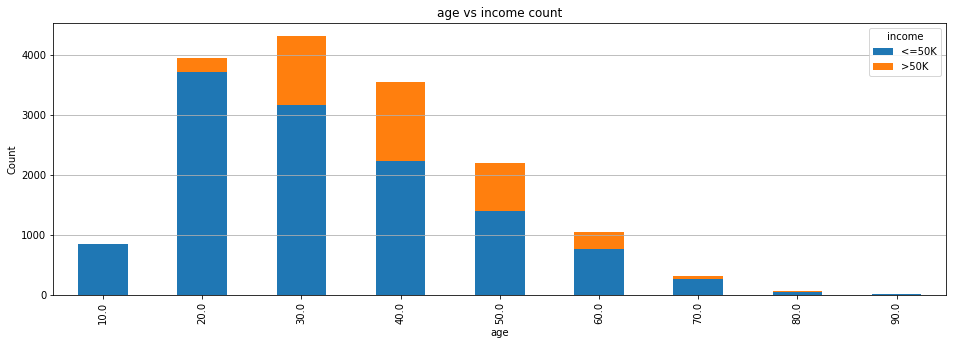

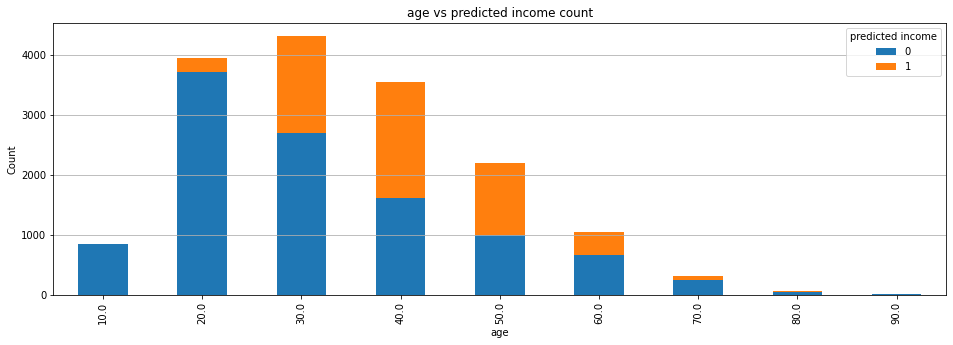

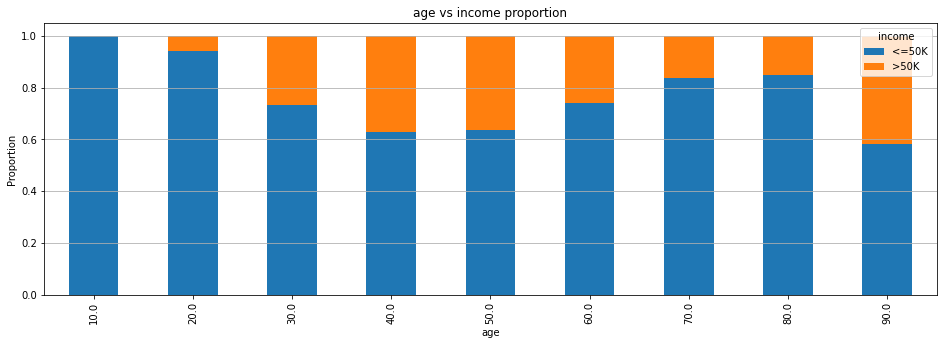

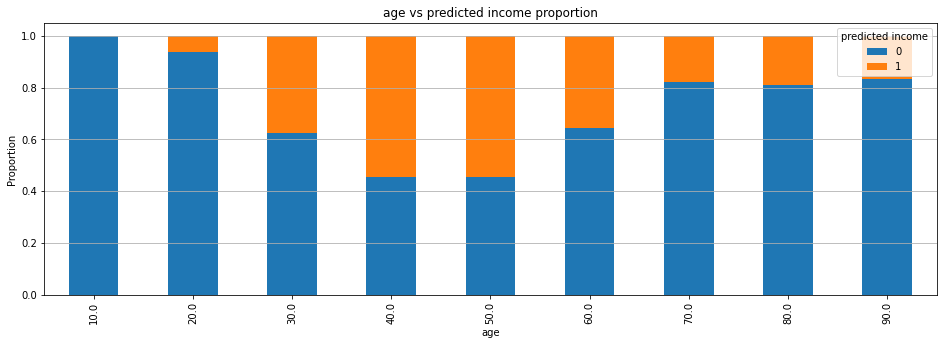

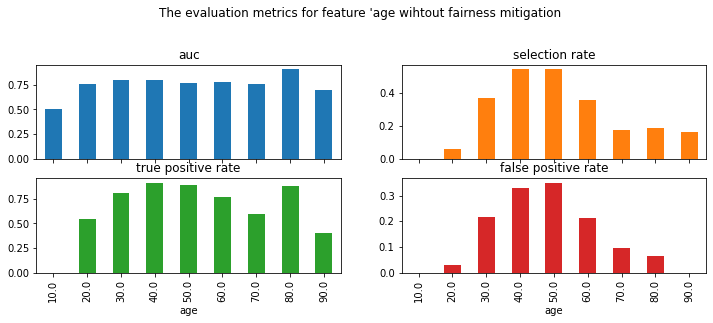

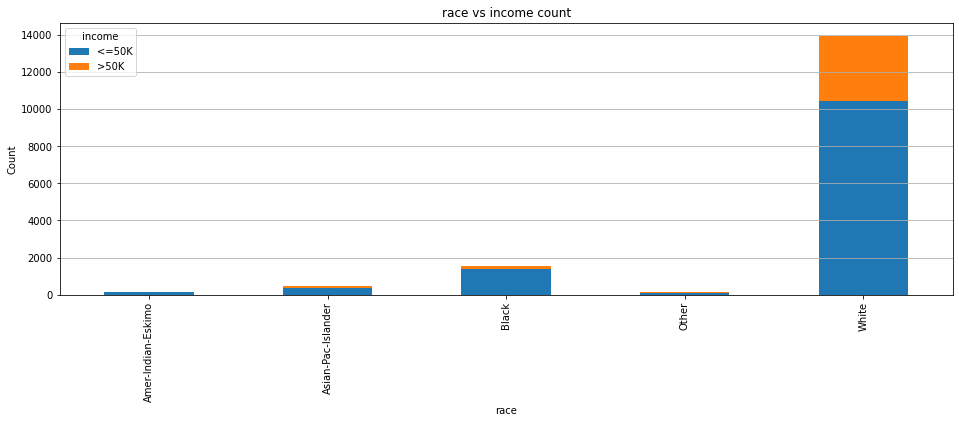

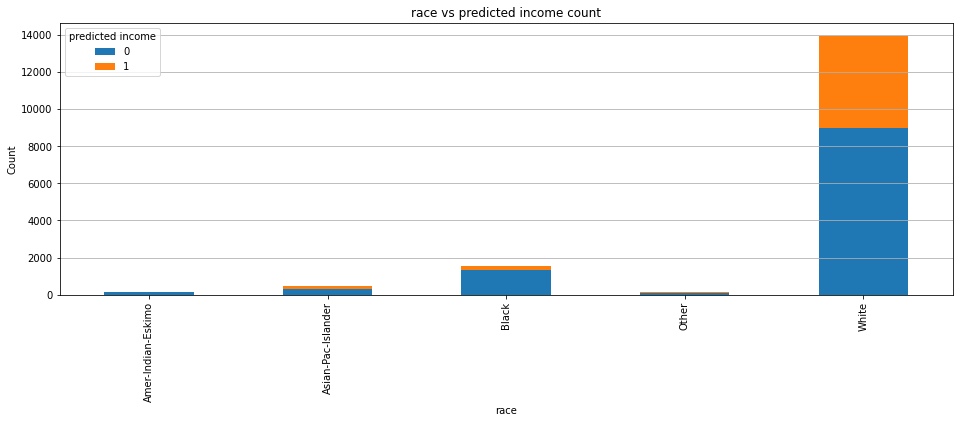

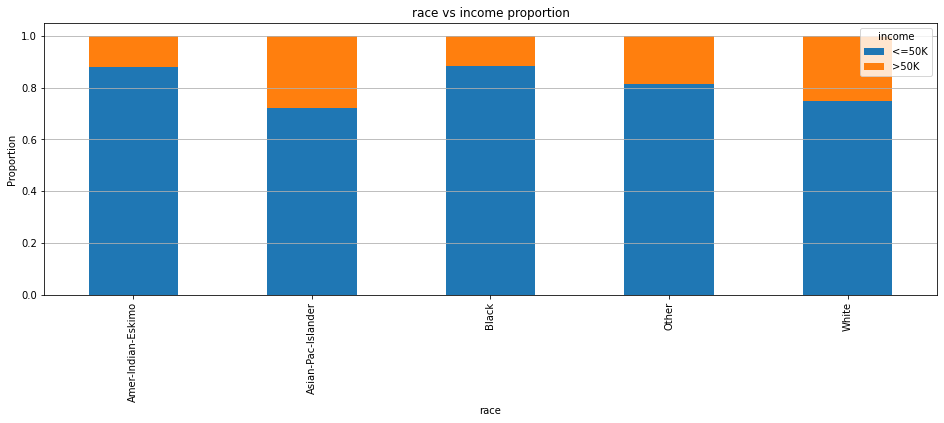

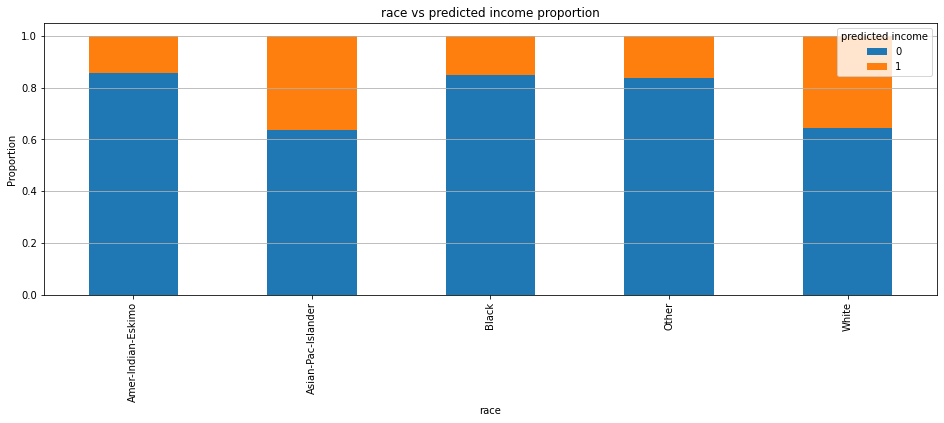

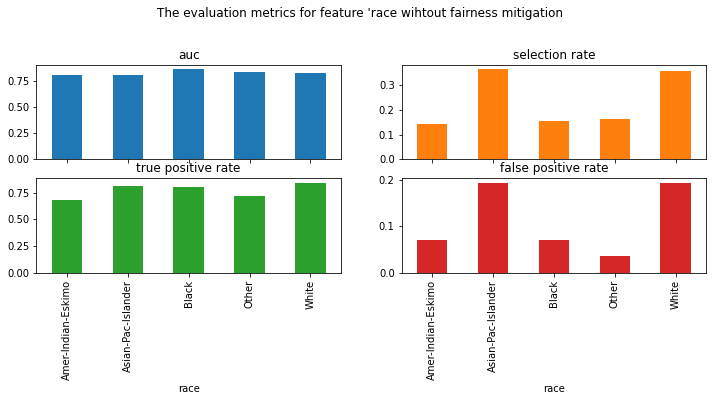

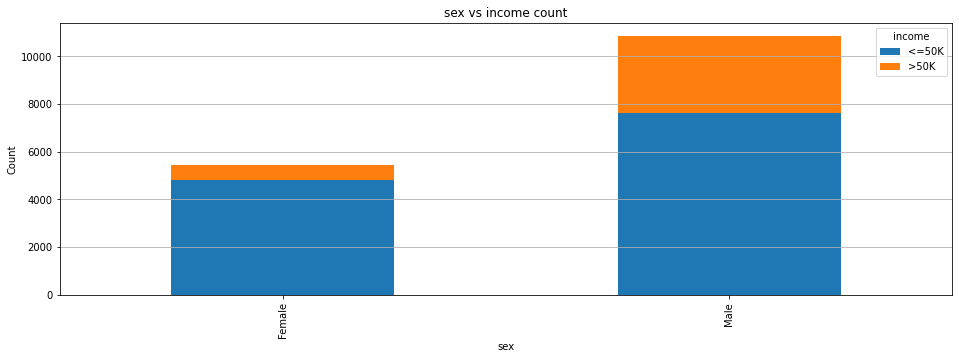

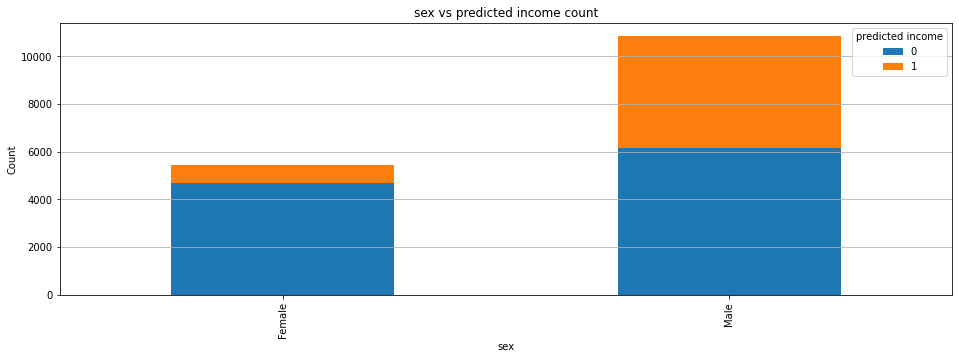

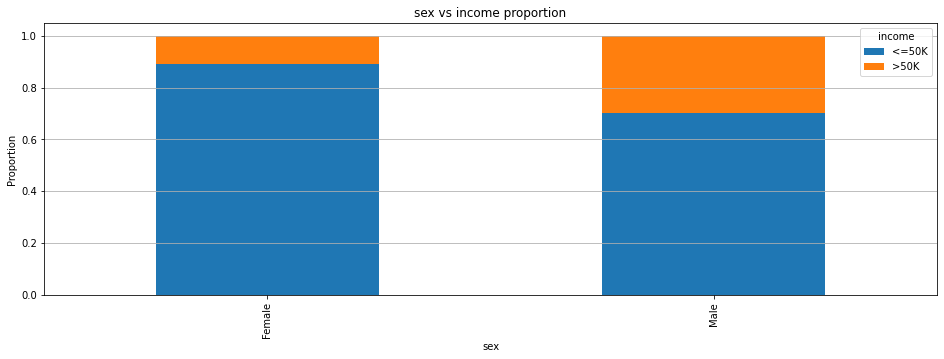

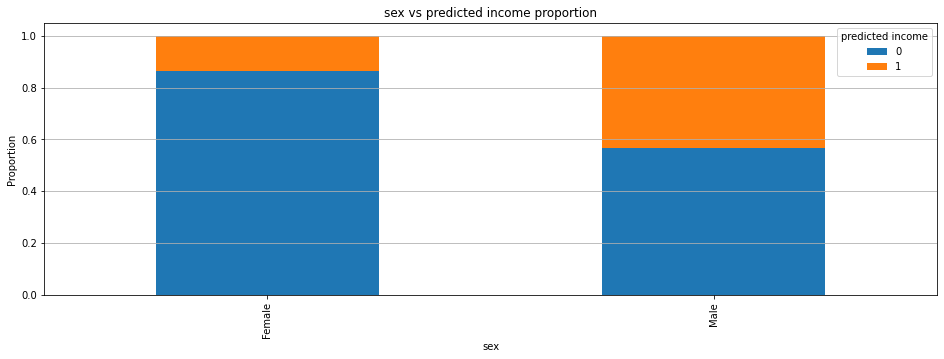

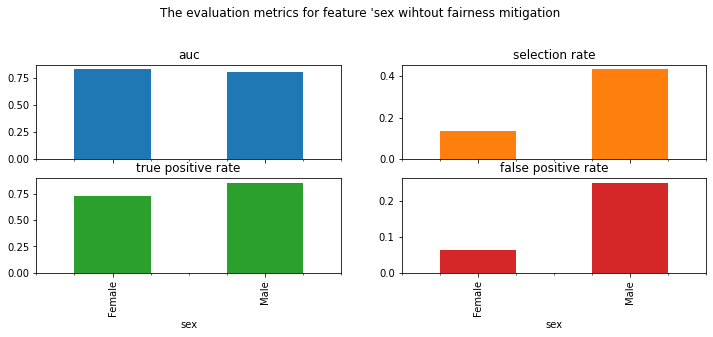

In [6]:
# Split the data into train and test
train = file_dataframe[file_dataframe.is_train==True].drop(columns=['is_train'])
test = file_dataframe[file_dataframe.is_train==False].drop(columns=['is_train'])

train = min_max_scaling(train)
test = min_max_scaling(test)

# Prepare train set's features and labels
X = train.drop(columns=[LABEL_COLUMN])
y = train[LABEL_COLUMN].astype(bool)

# Prepare test set's features and labels
X_test = test.drop(columns=[LABEL_COLUMN])
y_test = test[LABEL_COLUMN].astype(bool)

best_y_pred, best_auc, best_classifier = predict_all_classifiers(output_dir, X, y, X_test, y_test, negative_positive_ratio)

y_pred = best_y_pred
PRED_COLUMN = 'predicted '+ LABEL_COLUMN
preds = pd.DataFrame(y_pred, columns=[PRED_COLUMN])

file_dataframe = pd.concat([file_dataframe, categorical_columns_df], axis=1)

gold_data = file_dataframe[file_dataframe.is_train==False]
gold_data.reset_index(drop=True, inplace=True)
gold_data[LABEL_COLUMN].replace({False: '<=50K', True: '>50K'}, inplace=True)
gold_data.age = gold_data.age // 10 * 10

pred_data = pd.concat([gold_data, preds], axis=1)
pred_data[PRED_COLUMN].replace({False: '<=50K', True: '>50K'}, inplace=True)

for col in BIAS_COLUMNS:
    plotOccurence(gold_data, col, LABEL_COLUMN)
    plotOccurence(pred_data, col, PRED_COLUMN)
    plotProportion(gold_data, col, LABEL_COLUMN)
    plotProportion(pred_data, col, PRED_COLUMN)
    draw_fairlearn_figure(y_test, y_pred, gold_data[col], output_dir=output_dir, bias_feature=col)

In [ ]:


# fairness_output_dir = 'outputs/census/with_fairness'
# for bias_col in BIAS_COLUMNS:
#     print('Mitigated feature: ', bias_col)
#     path = f'{fairness_output_dir}/{bias_col}'
#     os.makedirs(path, exist_ok=True)
#     constraint = EqualizedOdds(difference_bound=0.01)
#     mitigator = ExponentiatedGradient(best_classifier, constraint)
#     mitigator.fit(X, y, sensitive_features=train_gold_data[bias_col])
#     y_pred_mitigated = mitigator.predict(X_test)

#     for col in BIAS_COLUMNS:
#         draw_fairlearn_figure(y_test, y_pred_mitigated, gold_data[col], output_dir=path, bias_feature=col)

Mitigated feature:  age
[19:36:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mitigated feature:  race
[19:36:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mitigated feature:  sex
[19:36:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


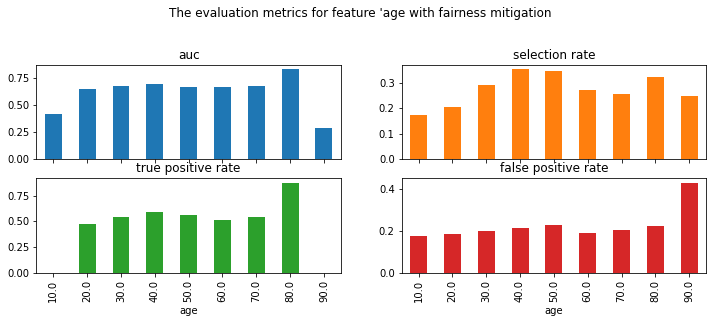

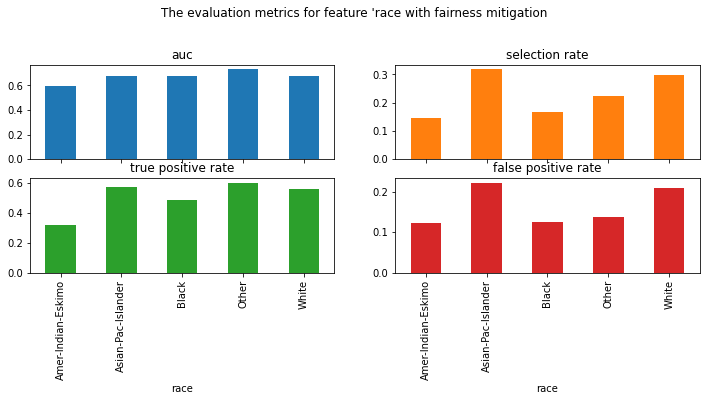

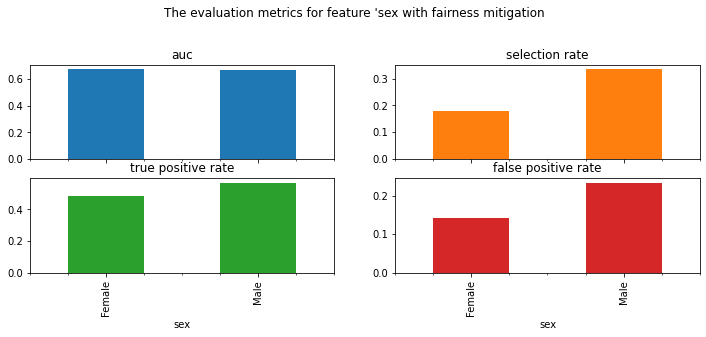

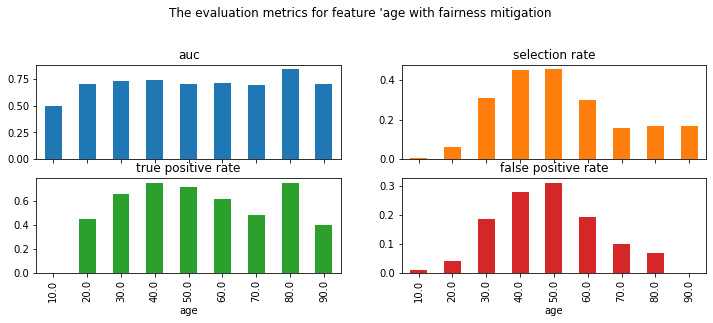

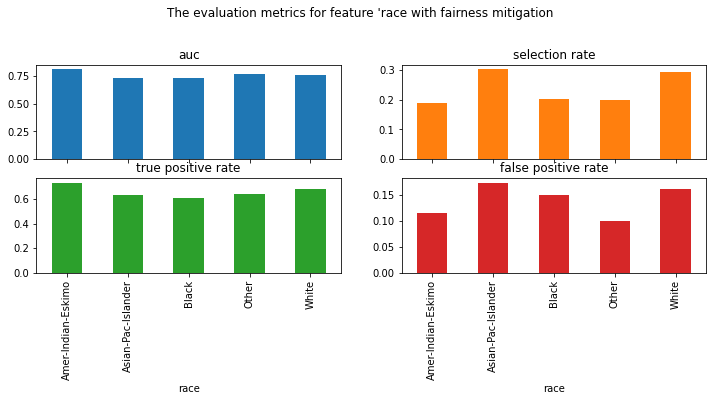

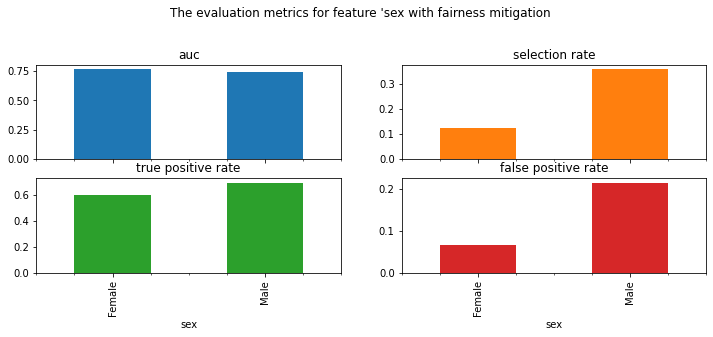

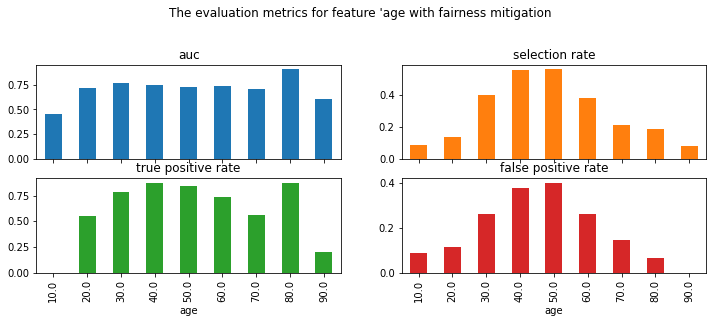

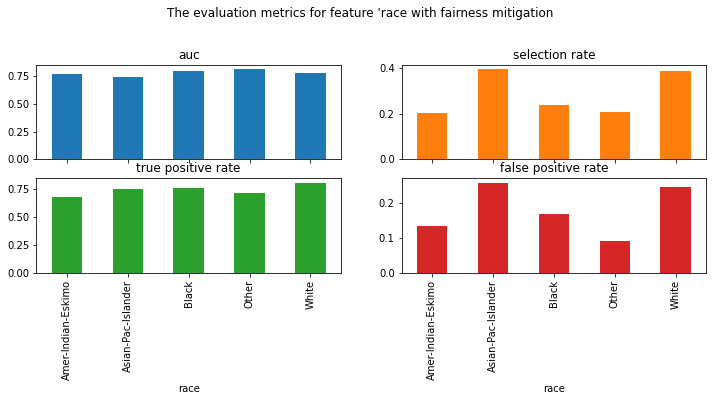

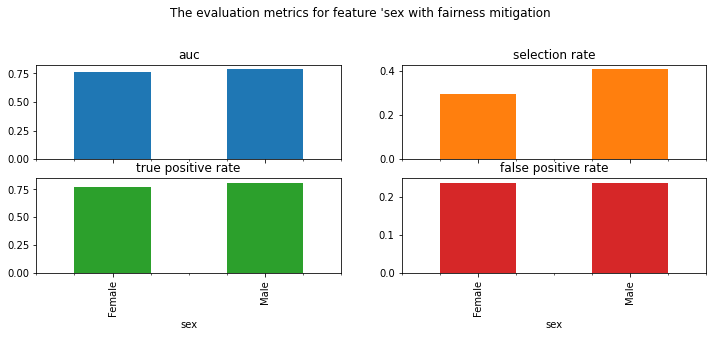

In [8]:
# Enforce fairness for each bias feature
train_gold_data = file_dataframe[file_dataframe.is_train==True]
train_gold_data.reset_index(drop=True, inplace=True)
train_gold_data[LABEL_COLUMN].replace({False: '<=50K', True: '>50K'}, inplace=True)
train_gold_data.age = train_gold_data.age // 10 * 10

fairness_output_dir = 'outputs/census/with_fairness'
for bias_col in BIAS_COLUMNS:
    print('Mitigated feature: ', bias_col)
    path = f'{fairness_output_dir}/{bias_col}'
    os.makedirs(path, exist_ok=True)
    mitigator = ThresholdOptimizer(estimator=best_classifier, constraints='equalized_odds', objective='balanced_accuracy_score')
    mitigator.fit(X, y, sensitive_features=train_gold_data[bias_col])
    y_pred_mitigated = mitigator.predict(X_test, sensitive_features=gold_data[bias_col])

    for col in BIAS_COLUMNS:
        draw_fairlearn_figure(y_test, y_pred_mitigated, gold_data[col], output_dir=path, bias_feature=col, text='with')